# ICML Paper Experiments: Hallucination Detection & Conformal Risk Control
 
This notebook analyzes the results from the local runs. It reproduces the tables and plots for:
 1. Comparison of Semantic Entropy vs. Accuracy Probes.
 2. Performance on "Confident Subsets" (Low Entropy).
 3. Combined Signal Performance.
 4. Conformal Risk-Coverage Trade-offs.

In [1]:
import os
import pickle
import yaml
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression

In [2]:
# Configuration
# Adjust this path to your local runs directory
PROJECT_ROOT = Path("/Users/edwardphillips/Documents/Oxford/Projects/conformal-probes")
RUNS_ROOT =  PROJECT_ROOT / "runs_local"
# Select the specific model and dataset you ran locally
MODEL_DIR_NAME = "Qwen3-1.7B__trivia_qa" # Example: matches the folder name in runs_local/\

## 1. Data Loading & Helper Functions
 
We need to load the generations (for hidden states and labels), uncertainty measures (for entropy), and the trained probes.

In [3]:
def find_files(run_dir):
    """Locate the latest wandb files directory."""
    user = os.environ.get("USER", os.getenv("USERNAME", ""))
    base_wandb = run_dir / user / "uncertainty" / "wandb"
    
    # Try latest-run symlink
    latest = base_wandb / "latest-run" / "files"
    if latest.exists():
        return latest
    
    # Fallback to search
    candidates = list(run_dir.rglob("files"))
    if not candidates:
        return None
    # Return newest
    return sorted(candidates, key=lambda p: p.stat().st_mtime)[-1]

def load_run_data(runs_root, model_dir_name):
    run_path = runs_root / model_dir_name
    files_dir = find_files(run_path)
    
    if not files_dir:
        raise FileNotFoundError(f"Could not find wandb files in {run_path}")
    
    print(f"Loading data from: {files_dir}")
    
    # 1. Load Generations (Hidden States & Accuracy)
    with open(files_dir / "validation_generations.pkl", "rb") as f:
        gens = pickle.load(f)
        
    # 2. Load Uncertainty Measures (Entropy)
    with open(files_dir / "uncertainty_measures.pkl", "rb") as f:
        unc = pickle.load(f)
        
    # 3. Load Trained Probes
    with open(files_dir / "probes.pkl", "rb") as f:
        probes_data = pickle.load(f)
        
    return gens, unc, probes_data

In [4]:
# Load the data
gens, unc, probes_data = load_run_data(RUNS_ROOT, MODEL_DIR_NAME)

Loading data from: /Users/edwardphillips/Documents/Oxford/Projects/conformal-probes/runs_local/Qwen3-1.7B__trivia_qa/edwardphillips/uncertainty/wandb/latest-run/files


# 2. Data Preprocessing & Splitting 
We must replicate the `train_test_split` logic from `train_probes.py` (Random State 42) to ensure we don't evaluate on the probe training data.

In [5]:
def extract_tensors(gens, unc, entropy_key="cluster_assignment_entropy", n_samples_cap=2000):
    # 1. Extract Accuracy
    # Note: gens is a dict, keys are IDs. 
    # We must ensure stable ordering (though usually insertion order is preserved in Py3.7+)
    # train_probes.py iterates values(), so we do the same.
    gen_values = list(gens.values())
    
    accuracies = np.array([g["most_likely_answer"]["accuracy"] for g in gen_values])
    
    # 2. Extract Entropy
    # Ensure this matches the length of generations (sometimes entropy calculation drops failed gens)
    entropies = np.array(unc["uncertainty_measures"][entropy_key])
    
    # 3. Extract Hidden States (TBG: Token Before Generation)
    # Source Shape: [Layers, 1, Dim] -> We want [Layers, Batch, Dim]
    # train_probes.py logic: stack -> squeeze(-2) -> transpose(0,1)
    
    tbg_raw = [g["most_likely_answer"]["emb_last_tok_before_gen"] for g in gen_values]
    
    # Check shape of first item to decide squeeze dim
    # Expected: (NumLayers, 1, Dim)
    tbg_tensor = torch.stack(tbg_raw) # [Batch, Layers, 1, Dim]
    tbg_tensor = tbg_tensor.squeeze(-2) # [Batch, Layers, Dim]
    tbg_tensor = tbg_tensor.transpose(0, 1).numpy() # [Layers, Batch, Dim]
    
    # 4. Truncate to match train_probes.py logic (min(n_samples, actual))
    n = min(n_samples_cap, tbg_tensor.shape[1])
    
    tbg_tensor = tbg_tensor[:, :n, :]
    accuracies = accuracies[:n]
    entropies = entropies[:n]
    
    return tbg_tensor, accuracies, entropies

# Extract
# Note: Check your sep_sweep.yaml for 'probes -> n_samples'. Default is usually 2000.
X_layers, y_acc, y_ent = extract_tensors(gens, unc, n_samples_cap=2000)

print(f"Data shapes: Hidden={X_layers.shape}, Acc={y_acc.shape}, Ent={y_ent.shape}")

# Define Hallucination Label: 1 if Accuracy < 1.0 (Wrong), 0 if Correct
y_hallucination = (y_acc < 1.0).astype(int)

Data shapes: Hidden=(29, 100, 2048), Acc=(100,), Ent=(100,)


In [6]:
# Replicate Splits from train_probes.py
# We split indices instead of data directly to keep track of everything
indices = np.arange(len(y_acc))

# 1. Split into (Train+Val) and Test (Held-out for final evaluation)
idx_train_val, idx_test = train_test_split(indices, test_size=0.1, random_state=42)

# 2. Split (Train+Val) into Probe-Train and Calibration
# Note: The probes were trained on `idx_train`. 
# We will use `idx_cal` to train the Combiner g(x) and fit Conformal Thresholds.
idx_train, idx_cal = train_test_split(idx_train_val, test_size=0.2, random_state=42)

print(f"Split Sizes: Train={len(idx_train)}, Cal={len(idx_cal)}, Test={len(idx_test)}")

Split Sizes: Train=72, Cal=18, Test=10


In [7]:
# Replicate Splits from train_probes.py (Random State 42)
indices = np.arange(len(y_acc))

# 1. Split into (Train+Val) and Test
idx_train_val, idx_test = train_test_split(indices, test_size=0.1, random_state=42)

# 2. Split (Train+Val) into Probe-Train and Calibration
# The probes were trained on `idx_train`. We use `idx_cal` for our Combiner training.
idx_train, idx_cal = train_test_split(idx_train_val, test_size=0.2, random_state=42)

print(f"Split Sizes: Train={len(idx_train)}, Cal={len(idx_cal)}, Test={len(idx_test)}")

Split Sizes: Train=72, Cal=18, Test=10


## 3. Generating Probe Scores

We will select a specific layer (e.g., 0.9 depth) and run the loaded logistic regression probes on the data.

In [8]:
def get_layer_index(total_layers, depth_frac=0.95):
    return int(total_layers * depth_frac)

# Select layer
n_layers = X_layers.shape[0]
layer_idx = get_layer_index(n_layers, 0.95)
if layer_idx >= n_layers: layer_idx = n_layers - 1
print(f"Using Layer {layer_idx} (Total: {n_layers})")

Using Layer 27 (Total: 29)


In [14]:
# Retrieve models from pickle
model_key = list(probes_data['results'].keys())[0] 
print(f"Loading probes for key: {model_key}")

acc_probe_model = probes_data['results'][model_key]['ta_models'][layer_idx]
se_probe_model = probes_data['results'][model_key]['tb_models'][layer_idx]

# Apply Probes to ALL data
X_selected_layer = X_layers[layer_idx]

# --- 1. Accuracy Probe ---
# Trained on: 0=Wrong, 1=Correct
# We want P(Hallucination), i.e., P(Wrong).
probs_acc = acc_probe_model.predict_proba(X_selected_layer)
score_acc_probe = probs_acc[:, 0] # Take Column 0 (P(Wrong))

# --- 2. Semantic Entropy Probe ---
# Trained on: 0=Low Ent, 1=High Ent
# We want P(Hallucination), which correlates with High Ent.
probs_se = se_probe_model.predict_proba(X_selected_layer)
score_se_probe = probs_se[:, 0] # Take Column 1 (P(High Ent))

# --- 3. Raw Entropy ---
score_se_raw = y_ent

# --- 4. Organize ---
df = pd.DataFrame({
    "y_true": y_hallucination, 
    "score_acc_probe": score_acc_probe,
    "score_se_probe": score_se_probe,
    "score_se_raw": score_se_raw,
    "split": ["train"] * len(y_hallucination) 
})

df.loc[idx_train, "split"] = "probe_train"
df.loc[idx_cal, "split"] = "calibration"
df.loc[idx_test, "split"] = "test"

df_test = df[df["split"] == "test"].copy()
df_cal = df[df["split"] == "calibration"].copy()

# --- 5. Sanity Check: Directionality ---
# All AUROCs should be > 0.5. If not, something is inverted.
print("-" * 30)
print("Directionality Check (AUROC > 0.5 means High Score = Hallucination):")
for col in ["score_acc_probe", "score_se_probe", "score_se_raw"]:
    auc = roc_auc_score(df_test['y_true'], df_test[col])
    print(f"{col}: {auc:.3f} " + ("✅" if auc > 0.5 else "❌ INVERTED!"))
print("-" * 30)

Loading probes for key: Qwen3-1.7B__trivia_qa
------------------------------
Directionality Check (AUROC > 0.5 means High Score = Hallucination):
score_acc_probe: 0.905 ✅
score_se_probe: 0.762 ✅
score_se_raw: 1.000 ✅
------------------------------


## 4. Analysis 1: Correlation & Single-Signal Performance

Reproducing Table 1: AUROC on full test set vs. "Confident Subset".

Pearson Correlation (AccProbe vs SE): 0.544

Table 1 Replication:
                       Method  AUROC (Full)  AUROC (Low Entropy)
0                   Acc Probe      0.904762                  0.5
1                    SE Probe      0.761905                  0.5
2  Semantic Entropy (Teacher)      1.000000                  0.5


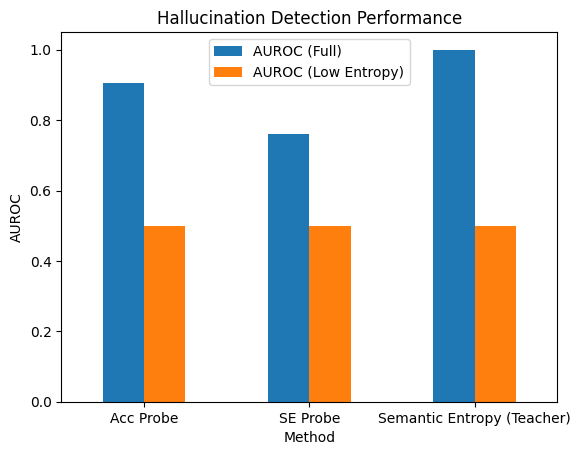

In [15]:
def compute_auroc(df_subset, score_col):
    if len(df_subset['y_true'].unique()) < 2: return 0.5
    return roc_auc_score(df_subset['y_true'], df_subset[score_col])

# 1. Correlation
corr = df_test[['score_acc_probe', 'score_se_raw']].corr().iloc[0,1]
print(f"Pearson Correlation (AccProbe vs SE): {corr:.3f}")

# 2. Confident Subset (Lowest 30% Entropy)
threshold_30 = df_test['score_se_raw'].quantile(0.30)
df_confident = df_test[df_test['score_se_raw'] <= threshold_30]

results = []
metrics = [
    ("Acc Probe", "score_acc_probe"),
    ("SE Probe", "score_se_probe"),
    ("Semantic Entropy (Teacher)", "score_se_raw")
]

for name, col in metrics:
    auc_full = compute_auroc(df_test, col)
    auc_conf = compute_auroc(df_confident, col)
    results.append({"Method": name, "AUROC (Full)": auc_full, "AUROC (Low Entropy)": auc_conf})

res_df = pd.DataFrame(results)
print("\nTable 1 Replication:")
print(res_df)

# Plot
res_df.set_index("Method")[["AUROC (Full)", "AUROC (Low Entropy)"]].plot(kind="bar", rot=0)
plt.title("Hallucination Detection Performance")
plt.ylabel("AUROC")
# plt.ylim(0.4, 1.0)
plt.show()

## 5. Analysis 2: Combined Signal Training

We train $g(x)$ using Logistic Regression on the **Calibration Split** to combine $f_{\mathrm{acc}}$ and $f_{\mathrm{se}}$.


In [16]:
# Train combiner on Calibration Split
X_cal_vals = df_cal[['score_acc_probe', 'score_se_probe']].values
y_cal_vals = df_cal['y_true'].values

combiner = LogisticRegression()
combiner.fit(X_cal_vals, y_cal_vals)

print(f"Combiner Coefficients: AccProbe={combiner.coef_[0][0]:.2f}, SEProbe={combiner.coef_[0][1]:.2f}")
# Both should ideally be positive

# --- FIX: Generate scores for BOTH splits ---
df_cal['score_combined'] = combiner.predict_proba(X_cal_vals)[:, 1]

X_test_vals = df_test[['score_acc_probe', 'score_se_probe']].values
df_test['score_combined'] = combiner.predict_proba(X_test_vals)[:, 1]

# Evaluate
threshold_30 = df_test['score_se_raw'].quantile(0.30)

auc_combined_full = compute_auroc(df_test, 'score_combined')
df_confident_v2 = df_test[df_test['score_se_raw'] <= threshold_30]
auc_combined_conf = compute_auroc(df_confident_v2, 'score_combined')

print(f"Combined AUROC (Full): {auc_combined_full:.3f}")
print(f"Combined AUROC (Low Entropy): {auc_combined_conf:.3f}")

Combiner Coefficients: AccProbe=0.50, SEProbe=-0.60
Combined AUROC (Full): 0.667
Combined AUROC (Low Entropy): 0.500


## 6. Analysis 3: Conformal Risk Control
We simulate a risk-control setting. We want to guarantee the hallucination rate among accepted answers is $<\alpha$. 

Algorithm:
 1. Use Calibration set.
 2. For a scoring function $S(x)$ (where higher = more likely hallucination), find threshold $\lambda$.
 3. Accept if $S(x) \le \lambda$.
 4. $\lambda = \inf \{ t : \frac{1}{N} \sum L(y_i, S(x_i) \le t) \le \alpha \}$. 
    Actually, we usually use the monotonic risk control formula:
    Find $\lambda$ such that Risk on Cal $\le \frac{N}{N+1}\alpha$.
 
 We plot Risk (Test) vs Coverage (Test) for varying targets $\alpha$.

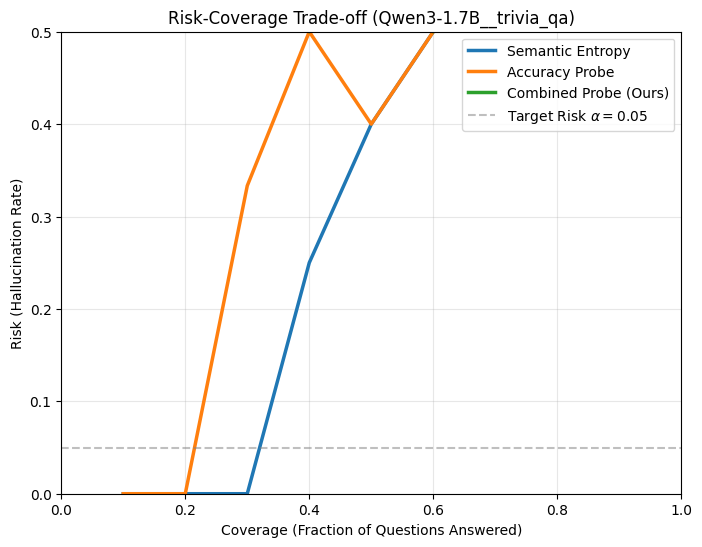

In [17]:
def get_risk_coverage_curve(df, score_col, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(df[score_col].min(), df[score_col].max(), 200)
    
    risks = []
    coverages = []
    
    for t in thresholds:
        # Accept if score <= t (Score is "Hallucination Probability")
        accepted = df[df[score_col] <= t]
        
        coverage = len(accepted) / len(df)
        if len(accepted) == 0:
            risk = 0.0
        else:
            # Risk = Mean Hallucination Rate in Accepted
            risk = accepted['y_true'].mean()
            
        risks.append(risk)
        coverages.append(coverage)
        
    return coverages, risks

# Generate Curves
methods = {
    "Semantic Entropy": "score_se_raw",
    "Accuracy Probe": "score_acc_probe",
    "Combined Probe (Ours)": "score_combined"
}

plt.figure(figsize=(8, 6))

for name, col in methods.items():
    cov, risk = get_risk_coverage_curve(df_test, col)
    # Sort for plotting
    sorted_pairs = sorted(zip(cov, risk))
    cov, risk = zip(*sorted_pairs)
    plt.plot(cov, risk, label=name, linewidth=2.5)

# Plot target lines
plt.axhline(0.05, color='gray', linestyle='--', alpha=0.5, label="Target Risk $\\alpha=0.05$")

plt.xlabel("Coverage (Fraction of Questions Answered)")
plt.ylabel("Risk (Hallucination Rate)")
plt.title(f"Risk-Coverage Trade-off ({MODEL_DIR_NAME})")
plt.legend()
plt.xlim(0, 1.0)
plt.ylim(0, 0.5) # Zoom in on low risk area
plt.grid(True, alpha=0.3)
plt.show()

## 7. Conformal Calibration Check
 
 Specifically verify if we meet the target $\alpha$ on the test set when threshold is chosen on calibration set.

In [18]:
def calibrate_threshold(df_cal, score_col, alpha):
    # Simple empirical risk control
    # Sort scores descending (hardest first? No, we accept score < t)
    # Let's sort scores ascending. 
    scores = np.sort(df_cal[score_col].values)
    
    # We want largest t such that risk <= alpha
    # Brute force scan for simplicity
    best_t = scores[0]
    
    # Scan through potential thresholds (the scores themselves)
    # This is O(N^2) naive, O(N) optimized. Since N is small here, naive is fine.
    # Risk calculation: cumsum(y_true) / range(1, N+1) if sorted by score
    
    # Efficient implementation:
    # 1. Attach labels to scores
    cal_data = df_cal[[score_col, 'y_true']].sort_values(score_col)
    
    # 2. Compute cumulative risk
    cal_data['cum_hallucinations'] = cal_data['y_true'].cumsum()
    cal_data['n_accepted'] = np.arange(1, len(cal_data) + 1)
    cal_data['current_risk'] = cal_data['cum_hallucinations'] / cal_data['n_accepted']
    
    # 3. Find max threshold where risk <= alpha
    valid_thresholds = cal_data[cal_data['current_risk'] <= alpha]
    
    if len(valid_thresholds) == 0:
        return -np.inf # Accept nothing
    
    return valid_thresholds[score_col].iloc[-1]

print("Conformal Verification (Target Risk alpha=0.10):")
print("-" * 50)
alpha = 0.10

# Add combined to methods list
methods_final = {
    "Semantic Entropy": "score_se_raw",
    "Accuracy Probe": "score_acc_probe",
    "Combined Probe": "score_combined"
}

for name, col in methods_final.items():
    # 1. Calibrate on df_cal
    t_star = calibrate_threshold(df_cal, col, alpha)
    
    # 2. Test on df_test
    test_accepted = df_test[df_test[col] <= t_star]
    test_coverage = len(test_accepted) / len(df_test)
    test_risk = test_accepted['y_true'].mean() if len(test_accepted) > 0 else 0.0
    
    print(f"{name:25s} | Threshold: {t_star:.4f} | Test Risk: {test_risk:.3f} | Coverage: {test_coverage:.3f}")

Conformal Verification (Target Risk alpha=0.10):
--------------------------------------------------
Semantic Entropy          | Threshold: 0.3251 | Test Risk: 0.000 | Coverage: 0.100
Accuracy Probe            | Threshold: 0.0314 | Test Risk: 0.000 | Coverage: 0.100
Combined Probe            | Threshold: 0.3226 | Test Risk: 1.000 | Coverage: 0.100
